In [23]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pickle as pk
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import stats
import numpy as np, scipy.stats as st
from sklearn.decomposition import PCA
import copy
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [24]:
receptor_df = pd.read_csv('../../../data/modeling_data/source_attribution/receptor_data.csv')

In [25]:
orig_df = receptor_df.copy()

In [26]:
# Wastewater also contains extra compounds that are not a part of the PFAS18 collection (PFDS, PFPeA, PFTeDA, PFPeS, PFNS, PFHpS)
# Remove these variables based on PFAS_18 compounds list

pfas18 = pd.read_csv('../../../data/Extracted lab report data/PFAS_compounds.csv')[['Acronym','PFAS18']]
pfas18 = pfas18[~(pfas18['PFAS18'].isna())]['Acronym']

In [27]:
pfas_vars = utils.get_pfas_vars(df = receptor_df,
                                pfas18 = pfas18)

## Explorator Data Analysis (EDA)
* We can see what the general profile looks like of the receptor well data

In [28]:
# Normalize from 0 to 1 for display purposes (e.g., EDA) only. The actual data will be z-score normalized (standardized) before PCA and HC.
receptor_df_eda = utils.normalize_over_partitions(df = receptor_df, 
                                              pfas_vars = pfas_vars,
                                              units_col = 'Matrix',
                                              scaler_fn = 'MinMax')

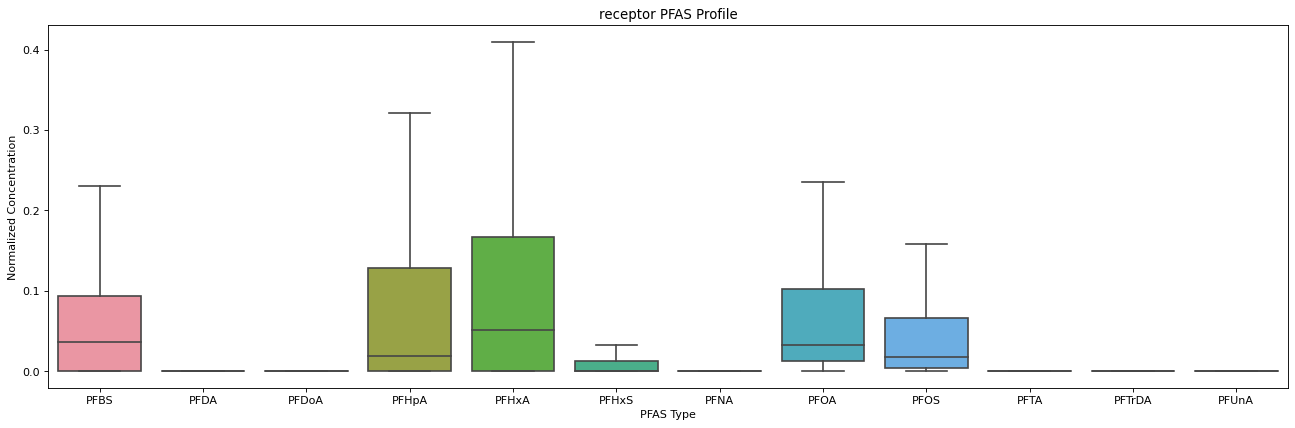

In [29]:
plt.figure(figsize=(20, 6), dpi=80)
plt.title('receptor PFAS Profile')

# pd.melt(receptor_df_eda[pfas_vars])
sns.boxplot(x="variable", y="value", data=pd.melt(receptor_df_eda[pfas_vars]), showfliers = False)
plt.xlabel('PFAS Type')
plt.ylabel('Normalized Concentration')
plt.show()

# Attribution Model

### Direct PCA Profile Method
* Advantages of this approach are that we are directly using the profile that we developed from the source data. Rather than interpolating the receptor well principal components. Makes for a 'truer' profile.

1) Run PCA & HC on receptor well information 

2) For each source: 

    * Use source PCA model, and transform receptor well data 

    * Use number of PCs found in source modeling --> Keep that amount PCs in transformed data. 

3) Create Poisson Regression models to predict PFAS amounts for each compound 

    * Predictors: Principal components, other relevant characteristics (if wanted) 

    * Response: Each PFAS compound (PFOS, PFOA etc...) 

4) Measure attribution of each principal component (source) by using relative measures of predicted PFAS amounts. 

    * Ex: Let's say there are only two relevant components. PFAS due to PC1 beta = 35 ng/l (across the state). PFAS due to PC2 beta = 65 ng/l (across the state) --> PC1 attribution = 35%, PC2 attribution = 65% 

### Transform using Profiles

In [30]:
num_pcs_dict = {'AFFF' : 3,
           'airport' : 2,
           'other' : 3,
           'residential' : 3}

other_PC_profiles_names = {'PC1' : 'Industrial Manufacturing Mix', 
                           'PC2' : 'Waste/Landfills', 
                           'PC3':'Other (Coatings/Inks and other)'}

Standardize receptor data

In [31]:
receptor_df_pca = copy.deepcopy(receptor_df)
receptor_df_pca = utils.normalize_over_partitions(df = receptor_df_pca, 
                                          pfas_vars = pfas_vars,
                                          units_col = 'Matrix',
                                          scaler_fn = 'Zscore')
input_df = receptor_df_pca[pfas_vars].copy()

AFFF

In [32]:
# Create AFFF transformation based on number of principal components
afff_df = pd.read_csv('../../../data/modeling_data/source_attribution/afff_source.csv')

afff_APCS_df = utils.APCS_pipeline(source_df = afff_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'AFFF',
                                   units_col = 'Matrix',
                                   num_pcs = num_pcs_dict)

Airport

In [33]:
# Create airport transformation based on number of principal components
airport_df = pd.read_csv('../../../data/modeling_data/source_attribution/airport_source.csv')

airport_APCS_df = utils.APCS_pipeline(source_df = airport_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'airport',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Other

In [34]:
# Create other transformation based on number of principal components
other_df = pd.read_csv('../../../data/modeling_data/source_attribution/other_source.csv')

other_APCS_df = utils.APCS_pipeline(source_df = other_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'other',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Residential

In [35]:
# Create residential transformation based on number of principal components
residential_df = pd.read_csv('../../../data/modeling_data/source_attribution/residential_source.csv')

residential_APCS_df = utils.APCS_pipeline(source_df = residential_df,
                                   receptor_df = receptor_df,
                                   receptor_df_pca = input_df,
                                   pfas_vars = pfas_vars,
                                   source_name = 'residential',
                                   units_col = 'Units',
                                   num_pcs = num_pcs_dict)

Create modeling dataset

In [36]:
sources = num_pcs_dict.keys()
concat_df = pd.concat([afff_APCS_df, airport_APCS_df, residential_APCS_df, other_APCS_df], axis = 1)
predictor_list = concat_df.columns
concat_df[pfas_vars] = receptor_df[pfas_vars]

### Attribution Modeling

Check for highly correlated variables

In [37]:
print('Top Absolute Correlations')
utils.get_top_abs_correlations(concat_df[predictor_list],
                        corr_cutoff = 0.9)

Top Absolute Correlations


,level_0,level_1,0
0,AFFF_1,other_1,0.970388
1,airport_0,residential_0,0.907751


Since airport_0 is most highly correlated with airport_0 -- if removed from model, then airport_0 will share contribution with residential_0. Since, airport_0 is not too highly correlated with AFFF_0 - no additional change beyond this is needed

In [38]:
# Manual entry
removed_vars = {'AFFF_1' : ['other_1'],
                'residential_0' : ['airport_0']}

In [39]:
for var, remove_list in removed_vars.items():
    concat_df.drop(columns = remove_list, inplace = True)
    
predictor_list = concat_df.columns

Fit model

In [40]:
# bootstrap 10 times to get confidence interval
n_iterations = 50
model2_info = utils.fit_model(concat_df, predictor_list, pfas_vars, n_iterations)

Calculate confidence intervals

In [41]:
source_names, means, yerror = utils.calc_contribution_confidence_intervals(concat_df, model2_info, pfas_vars, sources, n_iterations, removed_vars, num_pcs_dict, other_PC_profiles_names)

AFFF attribution 95% CI: [ 50.11 , 50.79 ] %
airport attribution 95% CI: [ 2.78 , 2.97 ] %
Industrial Manufacturing Mix attribution 95% CI: [ 0.84 , 1.11 ] %
Waste/Landfills attribution 95% CI: [ 35.9 , 36.1 ] %
Other (Coatings/Inks and other) attribution 95% CI: [ 0.48 , 0.56 ] %
residential attribution 95% CI: [ 8.94 , 9.42 ] %


([<matplotlib.axis.XTick at 0x12c71d47370>,
 [Text(0, 0, 'AFFF'),
  Text(1, 0, 'airport'),
  Text(2, 0, 'Industrial Manufacturing Mix'),
  Text(3, 0, 'Waste/Landfills'),
  Text(4, 0, 'Other (Coatings/Inks and other)'),
  Text(5, 0, 'residential')])

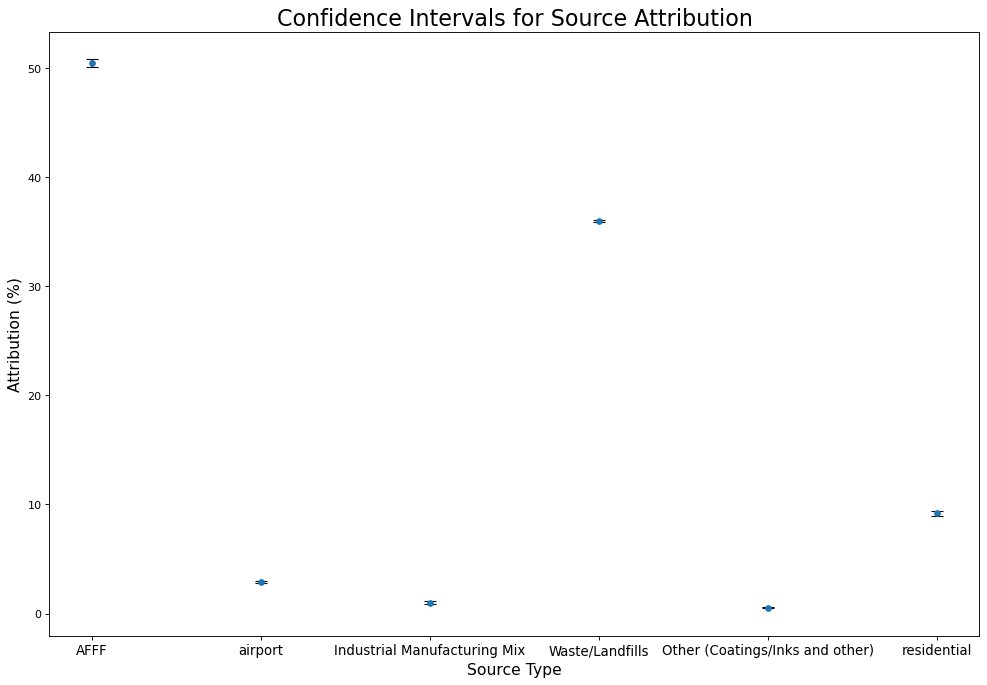

In [42]:
x = source_names
y = means

plt.figure(figsize=(15, 10), dpi=80)
plt.title('Confidence Intervals for Source Attribution', fontsize = 20)

plt.xlabel('Source Type', fontsize = 14)
plt.ylabel('Attribution (%)', fontsize = 14)

plt.errorbar(range(len(x)),y,yerr = yerror, fmt = 'o', ecolor = 'black', capsize = 5, ms = 5)
plt.xticks(range(len(x)), x,fontsize = 12)

In [43]:
# (Average variance explained by model, standard deviation)
utils.calculate_average_model_score(model2_info, n_iterations, sources, pfas_vars)

{'PFBS': (72.55, 3.75),
 'PFDA': (84.03, 2.18),
 'PFDoA': (55.21, 1.27),
 'PFHpA': (86.17, 1.51),
 'PFHxA': (82.29, 1.8),
 'PFHxS': (80.5, 2.82),
 'PFNA': (85.93, 1.8),
 'PFOA': (87.81, 1.04),
 'PFOS': (80.62, 1.97),
 'PFTA': (51.68, 1.53),
 'PFTrDA': (69.44, 11.12),
 'PFUnA': (53.58, 1.12)}